In [1]:
import torch
from torch import optim
from torch.utils.data import Subset, Dataset, DataLoader, IterableDataset, TensorDataset
import torchvision.transforms as T
import torch.nn.functional as F
# from torchvision.datasets import CIFAR10
from torchvision.utils import save_image
from tqdm import tqdm
from datetime import datetime
from torch.amp import autocast
import math
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer
# req torch, torchvision, einops, tqdm, ema_pytorch, accelerate
from IPython.display import display
from einops import rearrange, reduce, repeat
import glob
from ema_pytorch import EMA
from scipy.optimize import linear_sum_assignment
from accelerate import Accelerator
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple

import os
CWD = os.getcwd()

# Device stuff
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Device:", torch.cuda.get_device_name(0))
    print("Number of GPUs:", torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Remember to use {device} device from here on")
print(os.chdir("../"))
# %cd /home/physics/phuqza/E9/DDPM-HL-LHC/
from DDPMLHC.config import *
from DDPMLHC.calculate_quantities import *
from DDPMLHC.data_loading import *
from DDPMLHC.generate_plots.overlaid_1d import create_overlay_plots
from DDPMLHC.generate_plots.bmap import save_to_bmap
from DDPMLHC.generate_plots.histograms_1d import *
# from 


# Some functions from denoising_diffusion_pytorch that are required but couldn't import
def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))


/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/home/physics/phuftc/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA available: True
GPU Device: NVIDIA RTX A4000
Number of GPUs: 1
Remember to use cuda device from here on
None


In [2]:
def show_tensor_images(tensor_images, scale_factor=8):
    to_pil = T.ToPILImage()
    pil_images = [to_pil(image) for image in tensor_images]

    for img in pil_images:
        # Upscale the image
        upscaled_img = img.resize(
            (img.width * scale_factor, img.height * scale_factor), 
            Image.NEAREST  # or Image.BOX for smoother results
        )
        display(upscaled_img)


In [3]:
# Base code for training generated by Claude 3.5. Since modified for our purposes.
## Custom reimplementation of Trainer from DDPM
## Avoid subclassing because we do not want to pass in literal files

def load_and_train(
    diffusion,
    dataloader,
    num_epochs,
    device,
    save_dir,
    lr=1e-4
):
    os.makedirs(save_dir, exist_ok=True)
    loss_array = []
    # Get last epoch number
    checkpoint_files = glob.glob(os.path.join(save_dir, 'checkpoint_epoch_*.pth'))
    last_epoch = 0
    if checkpoint_files:
        epoch_numbers = []
        for f in checkpoint_files:
            try:
                epoch_num = int(f.split('epoch_')[1].split('_loss')[0])
                epoch_numbers.append(epoch_num)
            except:
                continue
        last_epoch = max(epoch_numbers) if epoch_numbers else 0

    # Load checkpoint if exists
    if last_epoch > 0:
        checkpoint_pattern = os.path.join(save_dir, f'checkpoint_epoch_{last_epoch}_*.pth')
        checkpoint_file = glob.glob(checkpoint_pattern)[0]
        print(f"Loading checkpoint: {checkpoint_file}")
        checkpoint = torch.load(checkpoint_file, map_location=device)
        diffusion.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("Starting fresh training")

    optimizer = optim.Adam(diffusion.parameters(), lr=lr)

    for epoch in range(last_epoch, last_epoch + num_epochs):
        print(f"\nEpoch {epoch + 1}/{last_epoch + num_epochs}")
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))

        running_loss = 0.0
        for i, images in progress_bar:
            images = images.to(device)
            optimizer.zero_grad()
            loss = diffusion(images)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            avg_loss = running_loss / (i + 1)
            progress_bar.set_postfix({'Loss': f'{avg_loss:.10f}'})
        loss_array.append(avg_loss)
        # Save checkpoint at the end of each epoch
        if epoch % 10 == 0:
            checkpoint_path = os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}_loss_{avg_loss:.10f}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': diffusion.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, checkpoint_path)
            print(f'Checkpoint saved: {checkpoint_path}')
    # Return array of final losses for plotting
    return loss_array


In [4]:

MAX_DATA_ROWS = None
bins=BMAP_SQUARE_SIDE_LENGTH

# === Read in data
print("0 :: Loading original data")
tt = np.genfromtxt(
    TT_PATH, delimiter=",", encoding="utf-8", skip_header=1, max_rows=MAX_DATA_ROWS
)
pu = np.genfromtxt(
    PILEUP_PATH, delimiter=",", encoding="utf-8", skip_header=1, max_rows=MAX_DATA_ROWS
)
tt = EventSelector(tt)
pu = EventSelector(pu)
print("FINISHED loading data\n")

# Ground truth ttbar jets
NG_jet = NoisyGenerator(TTselector=tt, PUselector=pu, bins=bins, mu=0)
# Second one to randomly generate and return pile-up events ONLY
## Will use np.random.randint to generate NoisyGenerator.mu and then call next
NG_pu = NoisyGenerator(TTselector=tt, PUselector=pu, bins=bins, mu=0, pu_only=True)

# class OutData():
#     def __init__(self, vector, axis=(0,0)):
#         pass



0 :: Loading original data
FINISHED loading data



In [5]:
class NGenForDataloader(Dataset):
    def __init__(self, noisy_generator, njets=100):
        self.ng = noisy_generator
        self.jets = []
        self.njets = njets
        # next(self.ng)
    def __iter__(self):
        return self
    
    def __len__(self):
        return self.ng._max_TT_no - 1
    
    def __getitem__(self, idx):
        self.ng.select_jet(idx)
        x = torch.from_numpy( self.ng.get_grid() ).float()
        # x = x.unsqueeze(0)
        x = x.unsqueeze(0)
        # self.jets.append(x)
        # print("x jet img", x.shape)
        # y = x
        return x


In [6]:
model = Unet(
    dim=64,                  # Base dimensionality of feature maps
    dim_mults=(1, 2, 4, 8),  # Multipliers for feature dimensions at each level
    channels=1,              # E.g. 3 for RGB
).to(device)

class PUDiffusion(GaussianDiffusion):
    def __init__(self, model, image_size, timesteps, puNG: NoisyGenerator, jet_ng: NoisyGenerator, **kwargs):
        super(PUDiffusion, self).__init__(model=model, image_size=image_size, timesteps=timesteps, **kwargs)
        self.puNG = puNG
        self.jetNG = jet_ng
        self.channels = model.channels
        self.mu_counter = 1
        self.timesteps = timesteps
    
#############################################################################################

    def cond_noise(self, x_shape, noise):
        return self.pu_to_tensor(x_shape) if noise is None else noise
        # return torch.zeros_like(x_start) if noise is None else noise
    def generate_data(self, shape, NG: NoisyGenerator):
        """
        This function generates image data matched to the correct shape
        """
        # Start next jet
        next(NG)
        selected = NG.get_grid()
        # If empty pile-up, return array of 0s instead since model should account for this
        if selected.size == 0:
            return  "Error in PUDiffusion.generate_jet"
        # print(selected_pu.shape)
        pu_tensor = torch.from_numpy(selected).float()

        pu_tensor = torch.unsqueeze(pu_tensor,0)
        # This tensor has dimensions BxCxHxW to match x_start
        pu_tensor = torch.unsqueeze(pu_tensor,0)
        pu_tensor = pu_tensor.expand(shape[0], shape[1], -1, -1) 
        # pu_tensor = torch.zeros(shape)
        pu_tensor = pu_tensor.to(self.device)
        return pu_tensor
    def pu_to_tensor(self, shape):
        # Select random number of pile-ups (mu) to generate, max 200 for now since HL-LHC expected to do up to this
        # We are doing it per batch
        # if isinstance(t, int):
        #     mu = np.random.randint(low=1, high=200, size=None)
        # else:
        #     mu = np.random.randint(low=1, high=200, size=None)
        mu = 1
        # print(mu)
        # Align jetIDs for correct centering of pile-up
        self.puNG._next_jetID = self.jetNG._next_jetID
        NG = self.puNG
        NG.mu = mu
        # NG.reset()
        # next(self.puNG)
        pu_tensor = self.generate_data(shape=shape, NG=NG)
        return pu_tensor
    def jet_to_tensor(self, shape):
        NG = self.jetNG
        # Align jetIDs for correct centering of pile-up
        self.puNG._next_jetID = self.jetNG._next_jetID
        # next(NG)
        pu_tensor = self.generate_data(shape=shape, NG=self.jetNG)
        return pu_tensor
    
    #############################################################################################
    
    @torch.inference_mode()
    def p_sample(self, x, t: int, x_self_cond = None):
        b, *_, device = *x.shape, self.device
        batched_times = torch.full((b,), t, device = device, dtype = torch.long)
        # print("batched times", t)
        model_mean, _, model_log_variance, x_start = self.p_mean_variance(x = x, t = batched_times, x_self_cond = x_self_cond, clip_denoised = True)
        ######## MODIFY
        noise = self.pu_to_tensor(x.shape) if t > 0 else 0 # no noise if t == 0
        pred_img = model_mean + (0.5 * model_log_variance).exp() * noise
        return pred_img, x_start
    @autocast('cuda', enabled = False)
    def q_sample(self, x_start, t, noise = None):
        noise = self.cond_noise(x_shape=x_start.shape, noise=noise)

        if self.immiscible:
            assign = self.noise_assignment(x_start, noise)
            noise = noise[assign]
        # print("q_sample t", t)
        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )
    def generate_noise(self,shape):
        batch, device = shape[0], self.device

        # img = torch.randn(shape, device = device)
        # This function is called in PUTrainer to sample jets
        # img = self.jet_to_tensor(shape=shape) # Geenerates a jet
        # Choose random jet
        jets = []
        # jet_indices = [16897, 54328, 7898, 2854]
        for i in range(batch):
            # random_jet_no = np.random.randint(low=0, high=self.jetNG._max_TT_no, size=None)
            self.jetNG._next_jetID = i
            # Prints jets to make images from
            # print(self.jetNG._next_jetID)
            # self.jetNG.select_jet(random_jet_no)  # or however you select jets
            self.jetNG.select_jet(i)  # or however you select jets
            
            jet = torch.from_numpy(self.jetNG.get_grid()).unsqueeze(0).float()
            # Now to add pile-up
            # random_pu_no = np.random.randint(low=0, high=self.jetNG._max_TT_no, size=None)
            self.puNG._next_jetID = self.jetNG._next_jetID
            # Start from 200 pileups
            self.puNG.mu = 200
            # Generate them
            next(self.puNG)
            selected_pu = self.puNG.get_grid()
            # If empty pile-up, return array of 0s instead since model should account for this
            # if selected.size == 0:
            #     return  "Error in PUDiffusion.generate_jet"
            # print(selected_pu.shape)
            pu_tensor = torch.from_numpy(selected_pu).float()
            # Get same shape, 1 x  grid x grid
            pu_tensor = torch.unsqueeze(pu_tensor,0)
            # pu_tensor = torch.unsqueeze(pu_tensor,0)
            # pu_tensor = pu_tensor.expand(shape[0], shape[1], -1, -1) 
            # pu_tensor = torch.zeros(shape)
            noised_jet = jet + pu_tensor # add energies element wise for each bin
            noised_jet = noised_jet.to(self.device)
            jets.append(noised_jet)
        # Should now  be batch x 1 x grid x grid
        jets = torch.stack(jets)
        jets = jets.to(self.device)
        return jets
   
    @torch.inference_mode()
    def p_sample_loop(self, shape, return_all_timesteps = False):
        # print("p sample loop")
        # print(shape)
        batch, device = shape[0], self.device
        img = self.generate_noise(shape)

        # img = img.to(self.device)
        imgs = [img]

        x_start = None

        for t in tqdm(reversed(range(0, self.num_timesteps)), desc = 'sampling loop time step', total = self.num_timesteps):
            # self_cond = x_start
            self_cond = x_start if self.self_condition else None
            img, x_start = self.p_sample(img, t, self_cond)
            imgs.append(img)

        ret = img if not return_all_timesteps else torch.stack(imgs, dim = 1)  # Returns intermediate imgs?

        ret = self.unnormalize(ret)
        print("final timestep: ", self.num_timesteps)
        return ret
    @torch.inference_mode()
    def sample(self, batch_size = 16, return_all_timesteps = False):
        (h, w), channels = self.image_size, self.channels
        # sample_fn = self.p_sample_loop if not self.is_ddim_sampling else self.ddim_sample
        sample_fn = self.p_sample_loop
        return sample_fn((batch_size, channels, h, w), return_all_timesteps = return_all_timesteps)


    def p_losses(self, x_start, t, noise = None, offset_noise_strength = None):
        b, c, h, w = x_start.shape
        # print(x_start.shape)
        # Select one pile-up at a time for each timestep $t$
        # single_pileup = self.pu.select_event(np.random.randint(low=0, high=self.pu.max_ID, size=1))
        # print("p_losses t", t)

        noise = self.cond_noise(x_start.shape, noise=noise)
        # noise = torch.zeros_like(x_start)

        # if noise is None: 
        # noise = default(noise, lambda: torch.randn_like(x_start))
        # offset_noise_strength = default(offset_noise_strength, self.offset_noise_strength)

        # if offset_noise_strength > 0:
        #     offset_noise = torch.randn(x_start.shape[:2], device = self.device)
        #     noise += offset_noise_strength * rearrange(offset_noise, 'b c -> b c 1 1')

        # noise sample

        x = self.q_sample(x_start = x_start, t = t, noise = noise)

        # if doing self-conditioning, 50% of the time, predict x_start from current set of times
        # and condition with unet with that
        # this technique will slow down training by 25%, but seems to lower FID significantly

        x_self_cond = None
        if self.self_condition and random() < 0.5:
            with torch.no_grad():
                x_self_cond = self.model_predictions(x, t).pred_x_start
                x_self_cond.detach_()

        # predict and take gradient step

        model_out = self.model(x, t, x_self_cond)

        if self.objective == 'pred_noise':
            target = noise
        elif self.objective == 'pred_x0':
            target = x_start
        elif self.objective == 'pred_v':
            v = self.predict_v(x_start, t, noise)
            target = v
        else:
            raise ValueError(f'unknown objective {self.objective}')

        loss = F.mse_loss(model_out, target, reduction = 'none')
        loss = reduce(loss, 'b ... -> b', 'mean')

        loss = loss * extract(self.loss_weight, t, loss.shape)
        return loss.mean()
    def forward(self, img, *args, **kwargs):
        # img = img.squeeze(0)
        # print("???", *img.shape)
        b, c, h, w, device, img_size, = *img.shape, img.device, self.image_size
        assert h == img_size[0] and w == img_size[1], f'height and width of image must be {img_size}'
        t = torch.randint(0, self.num_timesteps, (b,), device=device).long()
        
        img = self.normalize(img)
        return self.p_losses(img, t, *args, **kwargs)


In [7]:
# diffusion = GaussianDiffusion(
#     model = model,
#     image_size = 16,  # Size of your images (ensure your images are square)
#     timesteps = 1000,  # Number of diffusion steps
#     objective = "pred_x0",
# ).to(device)

diffusion = PUDiffusion(
    model = model,
    puNG = NG_pu,
    jet_ng= NG_jet,
    image_size = bins,  # Size of your images (ensure your images are square)
    timesteps = 200,  # Number of diffusion steps
    objective = "pred_x0",
    sampling_timesteps = None
).to(device)

sampling loop time step: 100%|██████████| 200/200 [00:02<00:00, 91.64it/s] 

final timestep:  200


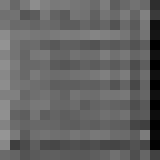

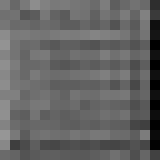

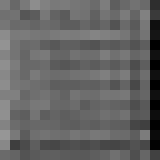

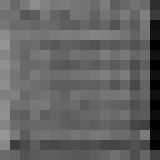

In [8]:
# Generate samples
batch_size = 4
# NG_jet.reset()
# NG_pu.reset()
sampled_images = diffusion.sample(batch_size=batch_size)
show_tensor_images(sampled_images, scale_factor=10)
# pats = [ng_for_dataloader[0],ng_for_dataloader[1],ng_for_dataloader[2],ng_for_dataloader[3],ng_for_dataloader[4],ng_for_dataloader[5], ng_for_dataloader[-1]]
# show_tensor_images(pats, scale_factor=10)

In [9]:
# this one is to be passed into DataLoader for training
train_batch_size = 200
ng_for_dataloader = NGenForDataloader(NG_jet)
dataloader = DataLoader(ng_for_dataloader, batch_size=train_batch_size, num_workers=2, shuffle = True, pin_memory = True)
save_dir = f"{CWD}/ML/4-PUnoise"
num_epochs = 100

xd = load_and_train(diffusion, dataloader, num_epochs=num_epochs, device=device, save_dir=save_dir, lr=1e-5)

print("Finished training")

Loading checkpoint: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_402_loss_0.0000151.pth

Epoch 403/502


100%|██████████| 355/355 [00:39<00:00,  9.07it/s, Loss=0.0000098]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_403_loss_0.0000098.pth

Epoch 404/502


100%|██████████| 355/355 [00:39<00:00,  8.92it/s, Loss=0.0000045]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_404_loss_0.0000045.pth

Epoch 405/502


100%|██████████| 355/355 [00:40<00:00,  8.85it/s, Loss=0.0000301]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_405_loss_0.0000301.pth

Epoch 406/502


100%|██████████| 355/355 [00:40<00:00,  8.82it/s, Loss=0.0000015]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_406_loss_0.0000015.pth

Epoch 407/502


100%|██████████| 355/355 [00:40<00:00,  8.81it/s, Loss=0.0000017]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_407_loss_0.0000017.pth

Epoch 408/502


100%|██████████| 355/355 [00:40<00:00,  8.79it/s, Loss=0.0000025]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_408_loss_0.0000025.pth

Epoch 409/502


100%|██████████| 355/355 [00:40<00:00,  8.79it/s, Loss=0.0000131]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_409_loss_0.0000131.pth

Epoch 410/502


100%|██████████| 355/355 [00:40<00:00,  8.78it/s, Loss=0.0000027]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_410_loss_0.0000027.pth

Epoch 411/502


100%|██████████| 355/355 [00:40<00:00,  8.78it/s, Loss=0.0000013]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_411_loss_0.0000013.pth

Epoch 412/502


100%|██████████| 355/355 [00:40<00:00,  8.78it/s, Loss=0.0000063]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_412_loss_0.0000063.pth

Epoch 413/502


100%|██████████| 355/355 [00:40<00:00,  8.77it/s, Loss=0.0000032]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_413_loss_0.0000032.pth

Epoch 414/502


100%|██████████| 355/355 [00:40<00:00,  8.77it/s, Loss=0.0000049]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_414_loss_0.0000049.pth

Epoch 415/502


100%|██████████| 355/355 [00:40<00:00,  8.77it/s, Loss=0.0000043]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_415_loss_0.0000043.pth

Epoch 416/502


100%|██████████| 355/355 [00:40<00:00,  8.77it/s, Loss=0.0000055]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_416_loss_0.0000055.pth

Epoch 417/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000104]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_417_loss_0.0000104.pth

Epoch 418/502


100%|██████████| 355/355 [00:40<00:00,  8.77it/s, Loss=0.0000024]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_418_loss_0.0000024.pth

Epoch 419/502


100%|██████████| 355/355 [00:40<00:00,  8.77it/s, Loss=0.0000039]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_419_loss_0.0000039.pth

Epoch 420/502


100%|██████████| 355/355 [00:40<00:00,  8.77it/s, Loss=0.0000024]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_420_loss_0.0000024.pth

Epoch 421/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000034]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_421_loss_0.0000034.pth

Epoch 422/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000104]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_422_loss_0.0000104.pth

Epoch 423/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000039]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_423_loss_0.0000039.pth

Epoch 424/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000024]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_424_loss_0.0000024.pth

Epoch 425/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000037]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_425_loss_0.0000037.pth

Epoch 426/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000057]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_426_loss_0.0000057.pth

Epoch 427/502


100%|██████████| 355/355 [00:40<00:00,  8.77it/s, Loss=0.0000033]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_427_loss_0.0000033.pth

Epoch 428/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000117]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_428_loss_0.0000117.pth

Epoch 429/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000013]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_429_loss_0.0000013.pth

Epoch 430/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000034]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_430_loss_0.0000034.pth

Epoch 431/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000017]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_431_loss_0.0000017.pth

Epoch 432/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000084]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_432_loss_0.0000084.pth

Epoch 433/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000040]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_433_loss_0.0000040.pth

Epoch 434/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000038]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_434_loss_0.0000038.pth

Epoch 435/502


100%|██████████| 355/355 [00:40<00:00,  8.75it/s, Loss=0.0000044]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_435_loss_0.0000044.pth

Epoch 436/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000031]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_436_loss_0.0000031.pth

Epoch 437/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000037]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_437_loss_0.0000037.pth

Epoch 438/502


100%|██████████| 355/355 [00:40<00:00,  8.75it/s, Loss=0.0000193]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_438_loss_0.0000193.pth

Epoch 439/502


100%|██████████| 355/355 [00:40<00:00,  8.75it/s, Loss=0.0000010]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_439_loss_0.0000010.pth

Epoch 440/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000030]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_440_loss_0.0000030.pth

Epoch 441/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000017]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_441_loss_0.0000017.pth

Epoch 442/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000026]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_442_loss_0.0000026.pth

Epoch 443/502


100%|██████████| 355/355 [00:40<00:00,  8.75it/s, Loss=0.0000040]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_443_loss_0.0000040.pth

Epoch 444/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000456]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_444_loss_0.0000456.pth

Epoch 445/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000010]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_445_loss_0.0000010.pth

Epoch 446/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000012]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_446_loss_0.0000012.pth

Epoch 447/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000011]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_447_loss_0.0000011.pth

Epoch 448/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000025]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_448_loss_0.0000025.pth

Epoch 449/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000039]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_449_loss_0.0000039.pth

Epoch 450/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000022]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_450_loss_0.0000022.pth

Epoch 451/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000188]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_451_loss_0.0000188.pth

Epoch 452/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000015]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_452_loss_0.0000015.pth

Epoch 453/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000015]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_453_loss_0.0000015.pth

Epoch 454/502


100%|██████████| 355/355 [00:40<00:00,  8.73it/s, Loss=0.0000016]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_454_loss_0.0000016.pth

Epoch 455/502


100%|██████████| 355/355 [00:40<00:00,  8.75it/s, Loss=0.0000574]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_455_loss_0.0000574.pth

Epoch 456/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000015]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_456_loss_0.0000015.pth

Epoch 457/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000010]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_457_loss_0.0000010.pth

Epoch 458/502


100%|██████████| 355/355 [00:40<00:00,  8.74it/s, Loss=0.0000009]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_458_loss_0.0000009.pth

Epoch 459/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000012]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_459_loss_0.0000012.pth

Epoch 460/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000029]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_460_loss_0.0000029.pth

Epoch 461/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000019]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_461_loss_0.0000019.pth

Epoch 462/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000028]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_462_loss_0.0000028.pth

Epoch 463/502


100%|██████████| 355/355 [00:40<00:00,  8.74it/s, Loss=0.0000126]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_463_loss_0.0000126.pth

Epoch 464/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000018]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_464_loss_0.0000018.pth

Epoch 465/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000034]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_465_loss_0.0000034.pth

Epoch 466/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000031]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_466_loss_0.0000031.pth

Epoch 467/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000145]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_467_loss_0.0000145.pth

Epoch 468/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000026]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_468_loss_0.0000026.pth

Epoch 469/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000017]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_469_loss_0.0000017.pth

Epoch 470/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000035]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_470_loss_0.0000035.pth

Epoch 471/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000032]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_471_loss_0.0000032.pth

Epoch 472/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000081]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_472_loss_0.0000081.pth

Epoch 473/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000025]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_473_loss_0.0000025.pth

Epoch 474/502


100%|██████████| 355/355 [00:40<00:00,  8.75it/s, Loss=0.0000014]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_474_loss_0.0000014.pth

Epoch 475/502


100%|██████████| 355/355 [00:40<00:00,  8.75it/s, Loss=0.0000021]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_475_loss_0.0000021.pth

Epoch 476/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000039]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_476_loss_0.0000039.pth

Epoch 477/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000143]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_477_loss_0.0000143.pth

Epoch 478/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000043]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_478_loss_0.0000043.pth

Epoch 479/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000033]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_479_loss_0.0000033.pth

Epoch 480/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000013]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_480_loss_0.0000013.pth

Epoch 481/502


100%|██████████| 355/355 [00:40<00:00,  8.74it/s, Loss=0.0000025]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_481_loss_0.0000025.pth

Epoch 482/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000117]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_482_loss_0.0000117.pth

Epoch 483/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000013]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_483_loss_0.0000013.pth

Epoch 484/502


100%|██████████| 355/355 [00:40<00:00,  8.77it/s, Loss=0.0000015]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_484_loss_0.0000015.pth

Epoch 485/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000020]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_485_loss_0.0000020.pth

Epoch 486/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000348]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_486_loss_0.0000348.pth

Epoch 487/502


100%|██████████| 355/355 [00:40<00:00,  8.75it/s, Loss=0.0000008]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_487_loss_0.0000008.pth

Epoch 488/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000009]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_488_loss_0.0000009.pth

Epoch 489/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000009]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_489_loss_0.0000009.pth

Epoch 490/502


100%|██████████| 355/355 [00:40<00:00,  8.71it/s, Loss=0.0000013]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_490_loss_0.0000013.pth

Epoch 491/502


100%|██████████| 355/355 [00:40<00:00,  8.75it/s, Loss=0.0000023]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_491_loss_0.0000023.pth

Epoch 492/502


100%|██████████| 355/355 [00:40<00:00,  8.75it/s, Loss=0.0000035]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_492_loss_0.0000035.pth

Epoch 493/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000011]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_493_loss_0.0000011.pth

Epoch 494/502


100%|██████████| 355/355 [00:40<00:00,  8.75it/s, Loss=0.0000051]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_494_loss_0.0000051.pth

Epoch 495/502


100%|██████████| 355/355 [00:40<00:00,  8.76it/s, Loss=0.0000111]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_495_loss_0.0000111.pth

Epoch 496/502


100%|██████████| 355/355 [00:40<00:00,  8.75it/s, Loss=0.0000019]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_496_loss_0.0000019.pth

Epoch 497/502


100%|██████████| 355/355 [00:40<00:00,  8.75it/s, Loss=0.0000009]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_497_loss_0.0000009.pth

Epoch 498/502


100%|██████████| 355/355 [00:40<00:00,  8.75it/s, Loss=0.0000125]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_498_loss_0.0000125.pth

Epoch 499/502


100%|██████████| 355/355 [00:40<00:00,  8.74it/s, Loss=0.0000042]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_499_loss_0.0000042.pth

Epoch 500/502


100%|██████████| 355/355 [01:00<00:00,  5.90it/s, Loss=0.0000013]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_500_loss_0.0000013.pth

Epoch 501/502


100%|██████████| 355/355 [01:07<00:00,  5.23it/s, Loss=0.0000030]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_501_loss_0.0000030.pth

Epoch 502/502


100%|██████████| 355/355 [01:28<00:00,  4.02it/s, Loss=0.0000033]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/ML/4-PUnoise/checkpoint_epoch_502_loss_0.0000033.pth
Finished training


In [10]:
# Set model to evaluation mode
model_cpu = model.to(torch.device("cpu"))
diffusion_cpu = diffusion.to(torch.device("cpu"))

model_cpu.eval()
diffusion_cpu.eval()



model.eval()
diffusion.eval()

PUDiffusion(
  (model): Unet(
    (init_conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (time_mlp): Sequential(
      (0): SinusoidalPosEmb()
      (1): Linear(in_features=64, out_features=256, bias=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=256, out_features=256, bias=True)
    )
    (downs): ModuleList(
      (0): ModuleList(
        (0-1): 2 x ResnetBlock(
          (mlp): Sequential(
            (0): SiLU()
            (1): Linear(in_features=256, out_features=128, bias=True)
          )
          (block1): Block(
            (proj): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): RMSNorm()
            (act): SiLU()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (block2): Block(
            (proj): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): RMSNorm()
            (act): SiLU()
            (dropout): Dropout(p=0.0, inpla

['data', 'DDPMLHC', 'jupyter.slurm', '__init__.py', 'LICENSE', 'run.sh', 'requirements.txt', 'README.md', '.gitignore', '.git', 'ML']
['./data/ML/second/checkpoint_epoch_46_loss_0.0000172.pth', './data/ML/second/checkpoint_epoch_3_loss_0.0021323.pth', './data/ML/second/checkpoint_epoch_4_loss_0.0020154.pth', './data/ML/second/checkpoint_epoch_51_loss_0.0000532.pth', './data/ML/second/checkpoint_epoch_45_loss_0.0000085.pth', './data/ML/second/checkpoint_epoch_37_loss_0.0000294.pth', './data/ML/second/checkpoint_epoch_29_loss_0.0001377.pth', './data/ML/second/checkpoint_epoch_34_loss_0.0000455.pth', './data/ML/second/checkpoint_epoch_9_loss_0.0004071.pth', './data/ML/second/checkpoint_epoch_15_loss_0.0001608.pth', './data/ML/second/checkpoint_epoch_31_loss_0.0000198.pth', './data/ML/second/checkpoint_epoch_10_loss_0.0004831.pth', './data/ML/second/checkpoint_epoch_33_loss_0.0000218.pth', './data/ML/second/checkpoint_epoch_6_loss_0.0005432.pth', './data/ML/second/checkpoint_epoch_27_loss_

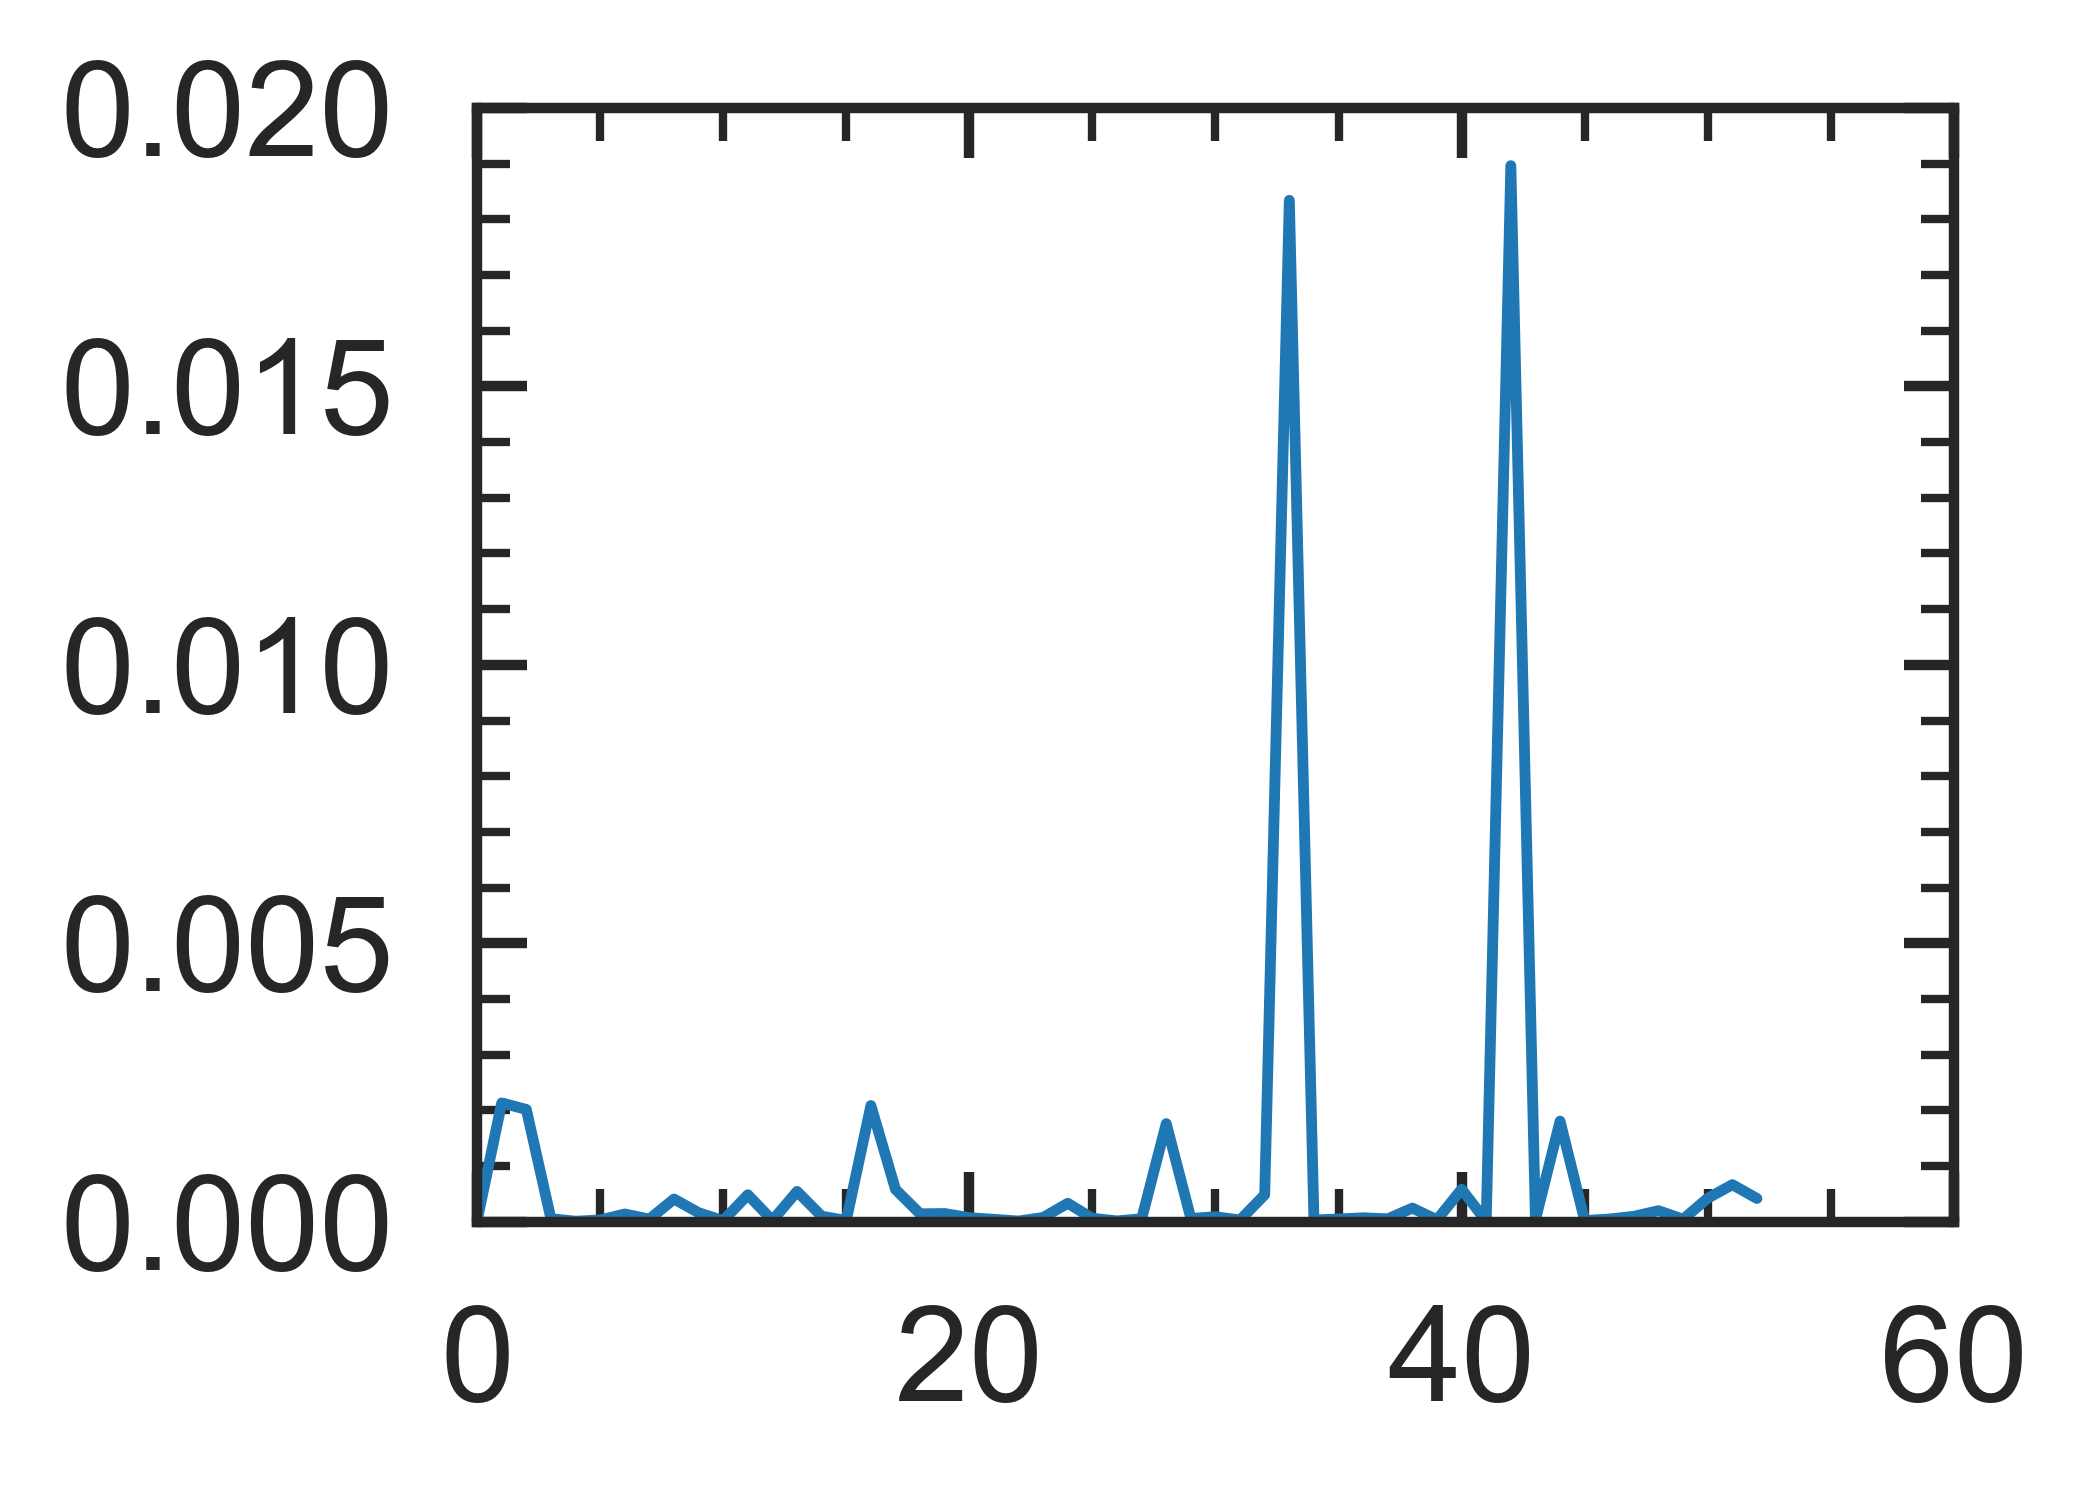

In [11]:
MPL_GLOBAL_PARAMS = {
    'text.usetex' : False, # use latex text
    'text.latex.preamble' : r'\usepackage{type1cm}\usepackage{braket}\usepackage{amssymb}\usepackage{amsmath}\usepackage{txfonts}', # latex packages
    'font.size' : 24,
    'figure.dpi' : 600,
    'figure.figsize' : (4, 3),
    'figure.autolayout' : True, # tight layout (True) or not (False)
    'axes.labelpad' : 5,
    'axes.xmargin' : 0,
    'axes.ymargin' : 0,
    'axes.grid' : False,
    'axes.autolimit_mode' : 'round_numbers', # set axis limits by rounding min/max values
    # 'axes.autolimit_mode' : 'data', # set axis limits as min/max values
    'xtick.major.pad' : 10,
    'ytick.major.pad' : 10,
    'xtick.labelsize': label_fontsize,
    'ytick.labelsize': label_fontsize,
    'lines.linewidth' : 1.3,
    'xtick.direction' : 'in',
    'ytick.direction' : 'in',
    'xtick.top' : True,
    'ytick.right' : True,
    'xtick.minor.visible' : True,
    'ytick.minor.visible' : True,
    'axes.prop_cycle': cycler(color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']*3),
    'legend.framealpha': None
  }
mpl.rcParams.update(MPL_GLOBAL_PARAMS)

import glob
import re
import os

def get_losses_from_checkpoints(checkpoint_dir='./data/ML/second'):
    # Get absolute path to checkpoint directory
    print(os.listdir("."))
    checkpoint_pattern = os.path.join(checkpoint_dir, 'checkpoint_epoch_*_loss_*.pth')
    
    # Get all matching files
    files = glob.glob(checkpoint_pattern)
    print(files)
    losses = []
    pattern = r'loss_([\d.]+)\.pth'
    
    for file in files:
        match = re.search(pattern, file)
        if match:
            loss = float(match.group(1))
            losses.append(loss)
    
    return len(files), losses

# Usage:
num_files, losses = get_losses_from_checkpoints()  
print(f"Number of checkpoint files: {num_files}")
print(f"Losses: {losses}")

fig = plt.figure()
# num,losses = get_losses_from_checkpoints()
plt.plot(list(range(num_files)),losses)
plt.show()

In [12]:
# Generate samples
# NG_jet.reset()
# NG_pu.reset()
# sampled_images = diffusion.sample(batch_size=100)
batch_size = int(3000)
sampled_images = diffusion_cpu.sample(batch_size=batch_size)
rescaled = sampled_images * NG_jet.max_energy
rescaled_np = rescaled.numpy()

# Move model to CPU after training

# print(sampled_images)
# show_tensor_images(rescaled, scale_factor=10)
# next(NG_pu)
# next(NG_jet)
# sampled_images = diffusion.sample(batch_size=1)
# show_tensor_images(sampled_images, scale_factor=10)
# import gc

# diffusion.cpu()
# del diffusion, checkpoint
# gc.collect()
# torch.cuda.empty_cache()


sampling loop time step: 100%|██████████| 200/200 [46:01<00:00, 13.81s/it]

final timestep:  200


Doing mu = 200...
Final idx (#events - 1):  2999.0
Plotting single histograms...
Plotting combined histogram...
Done mu = 200.



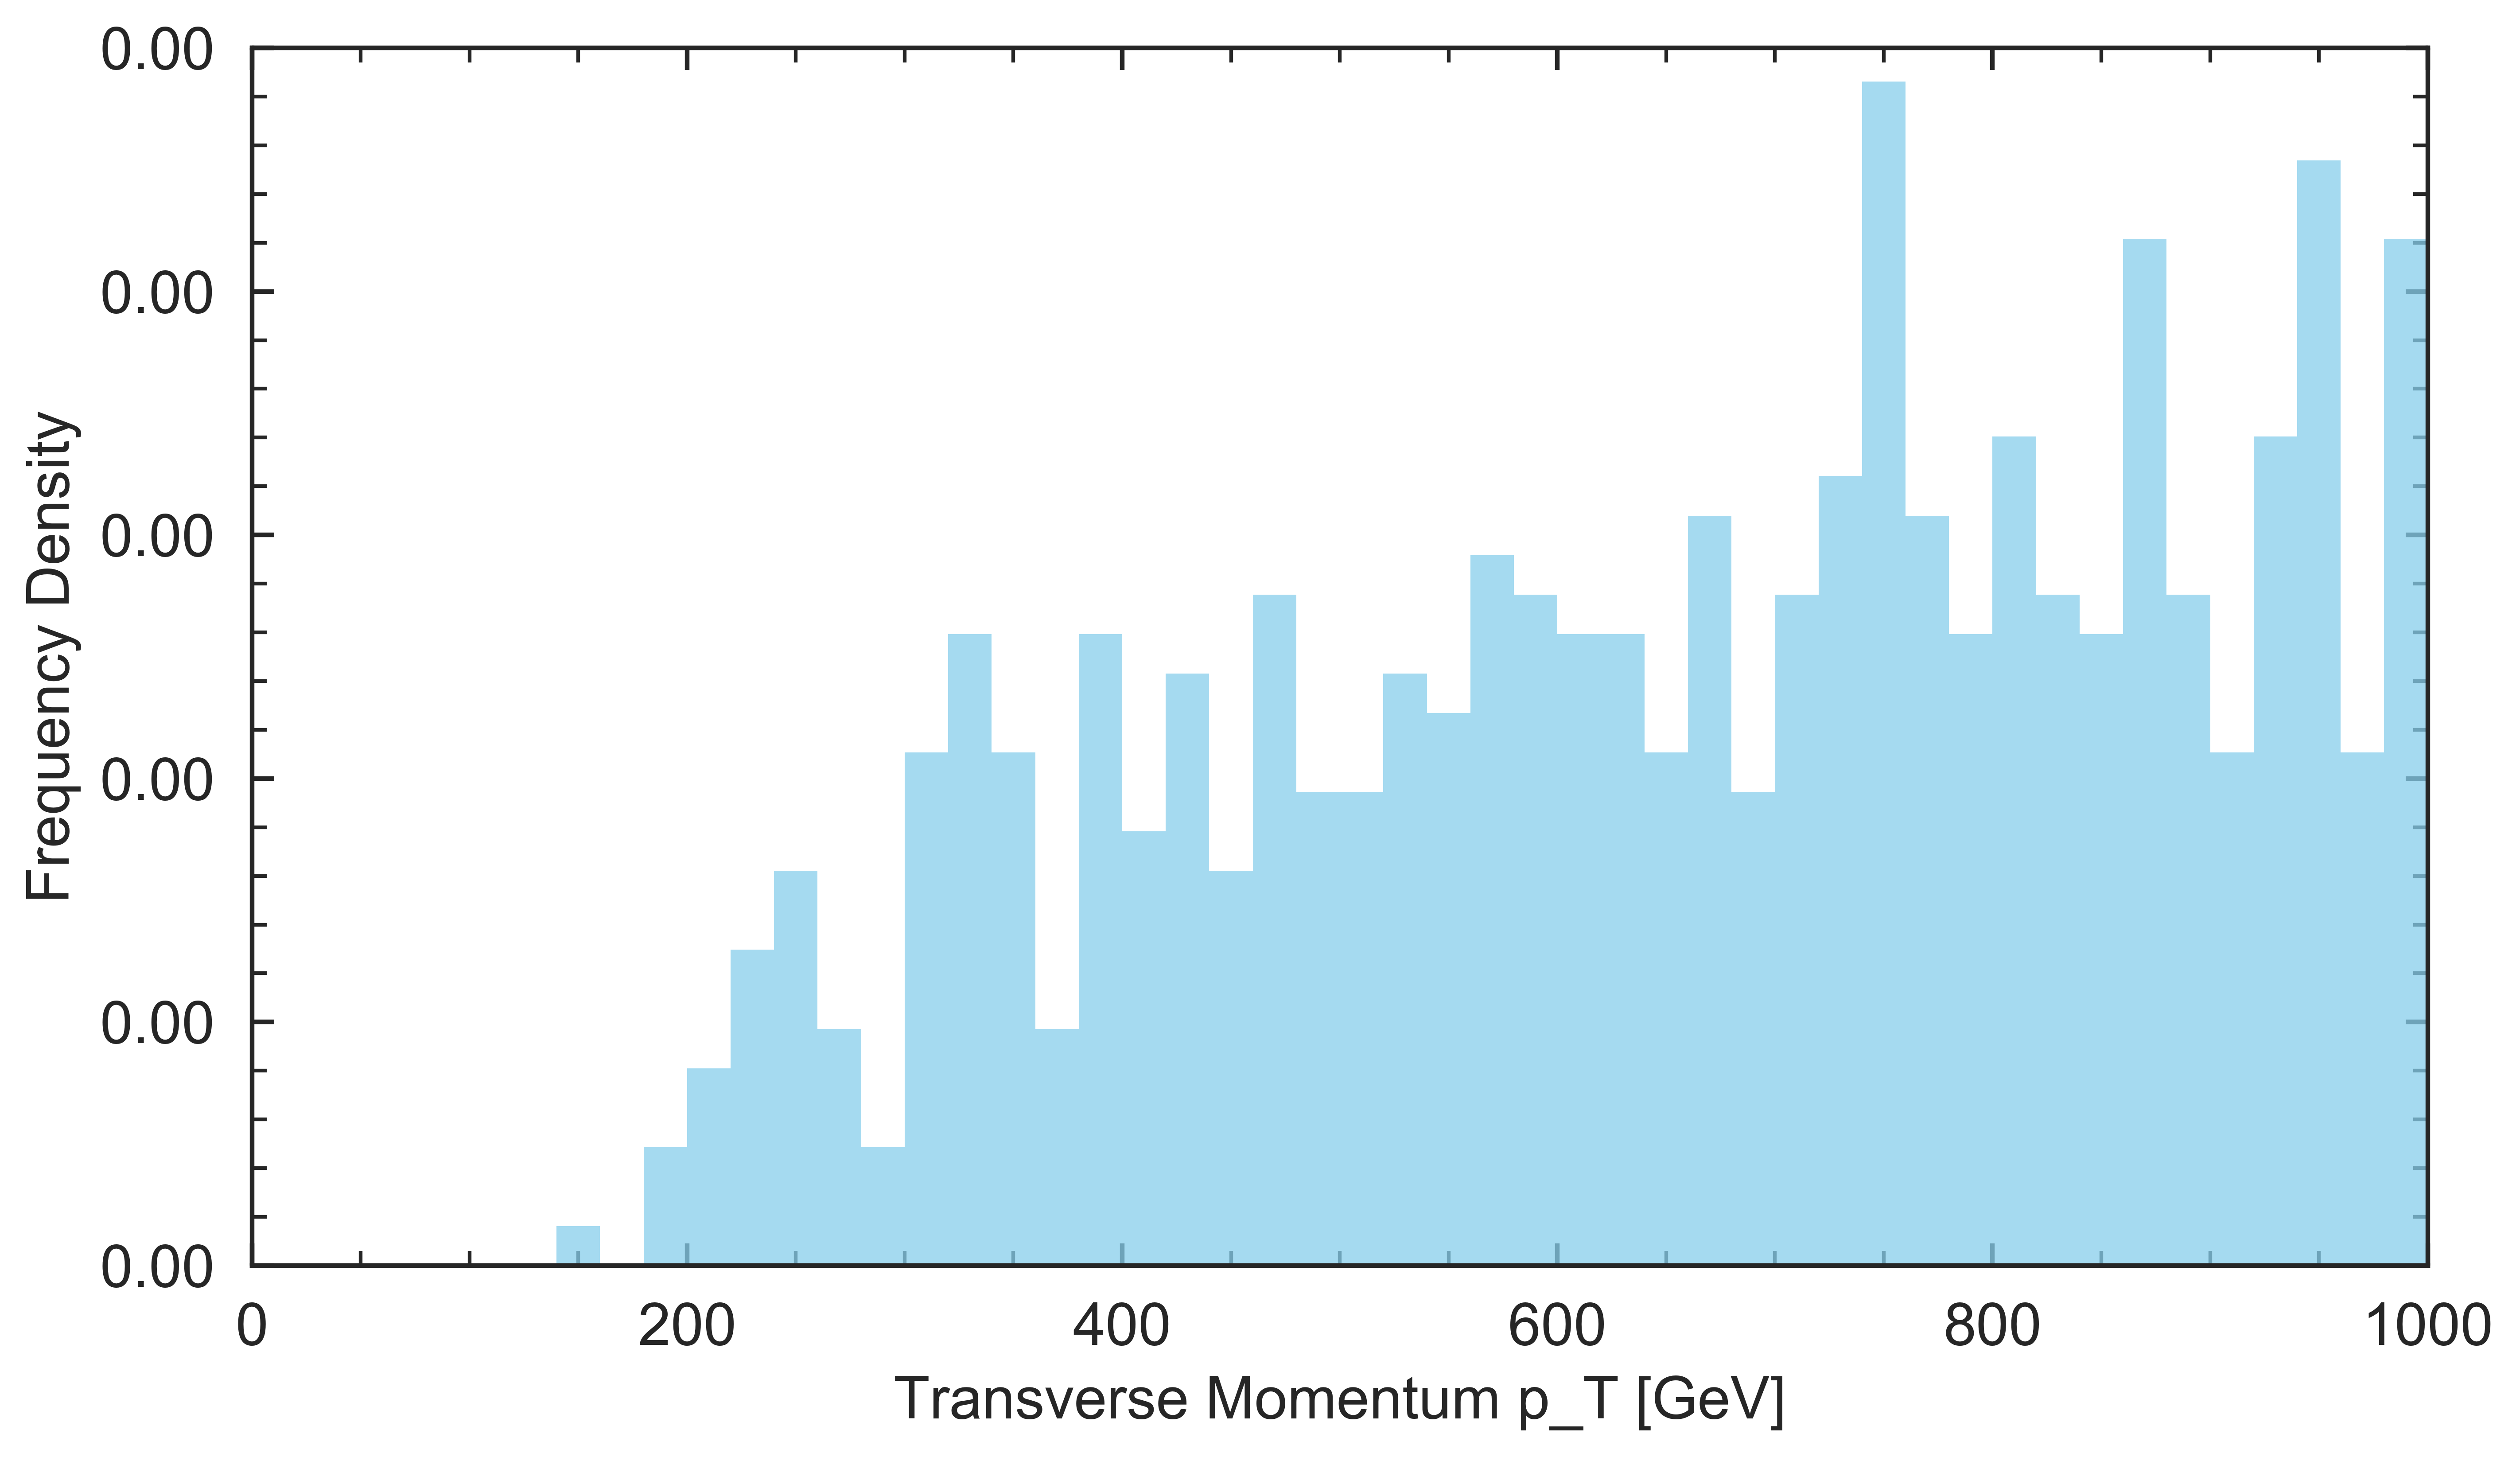

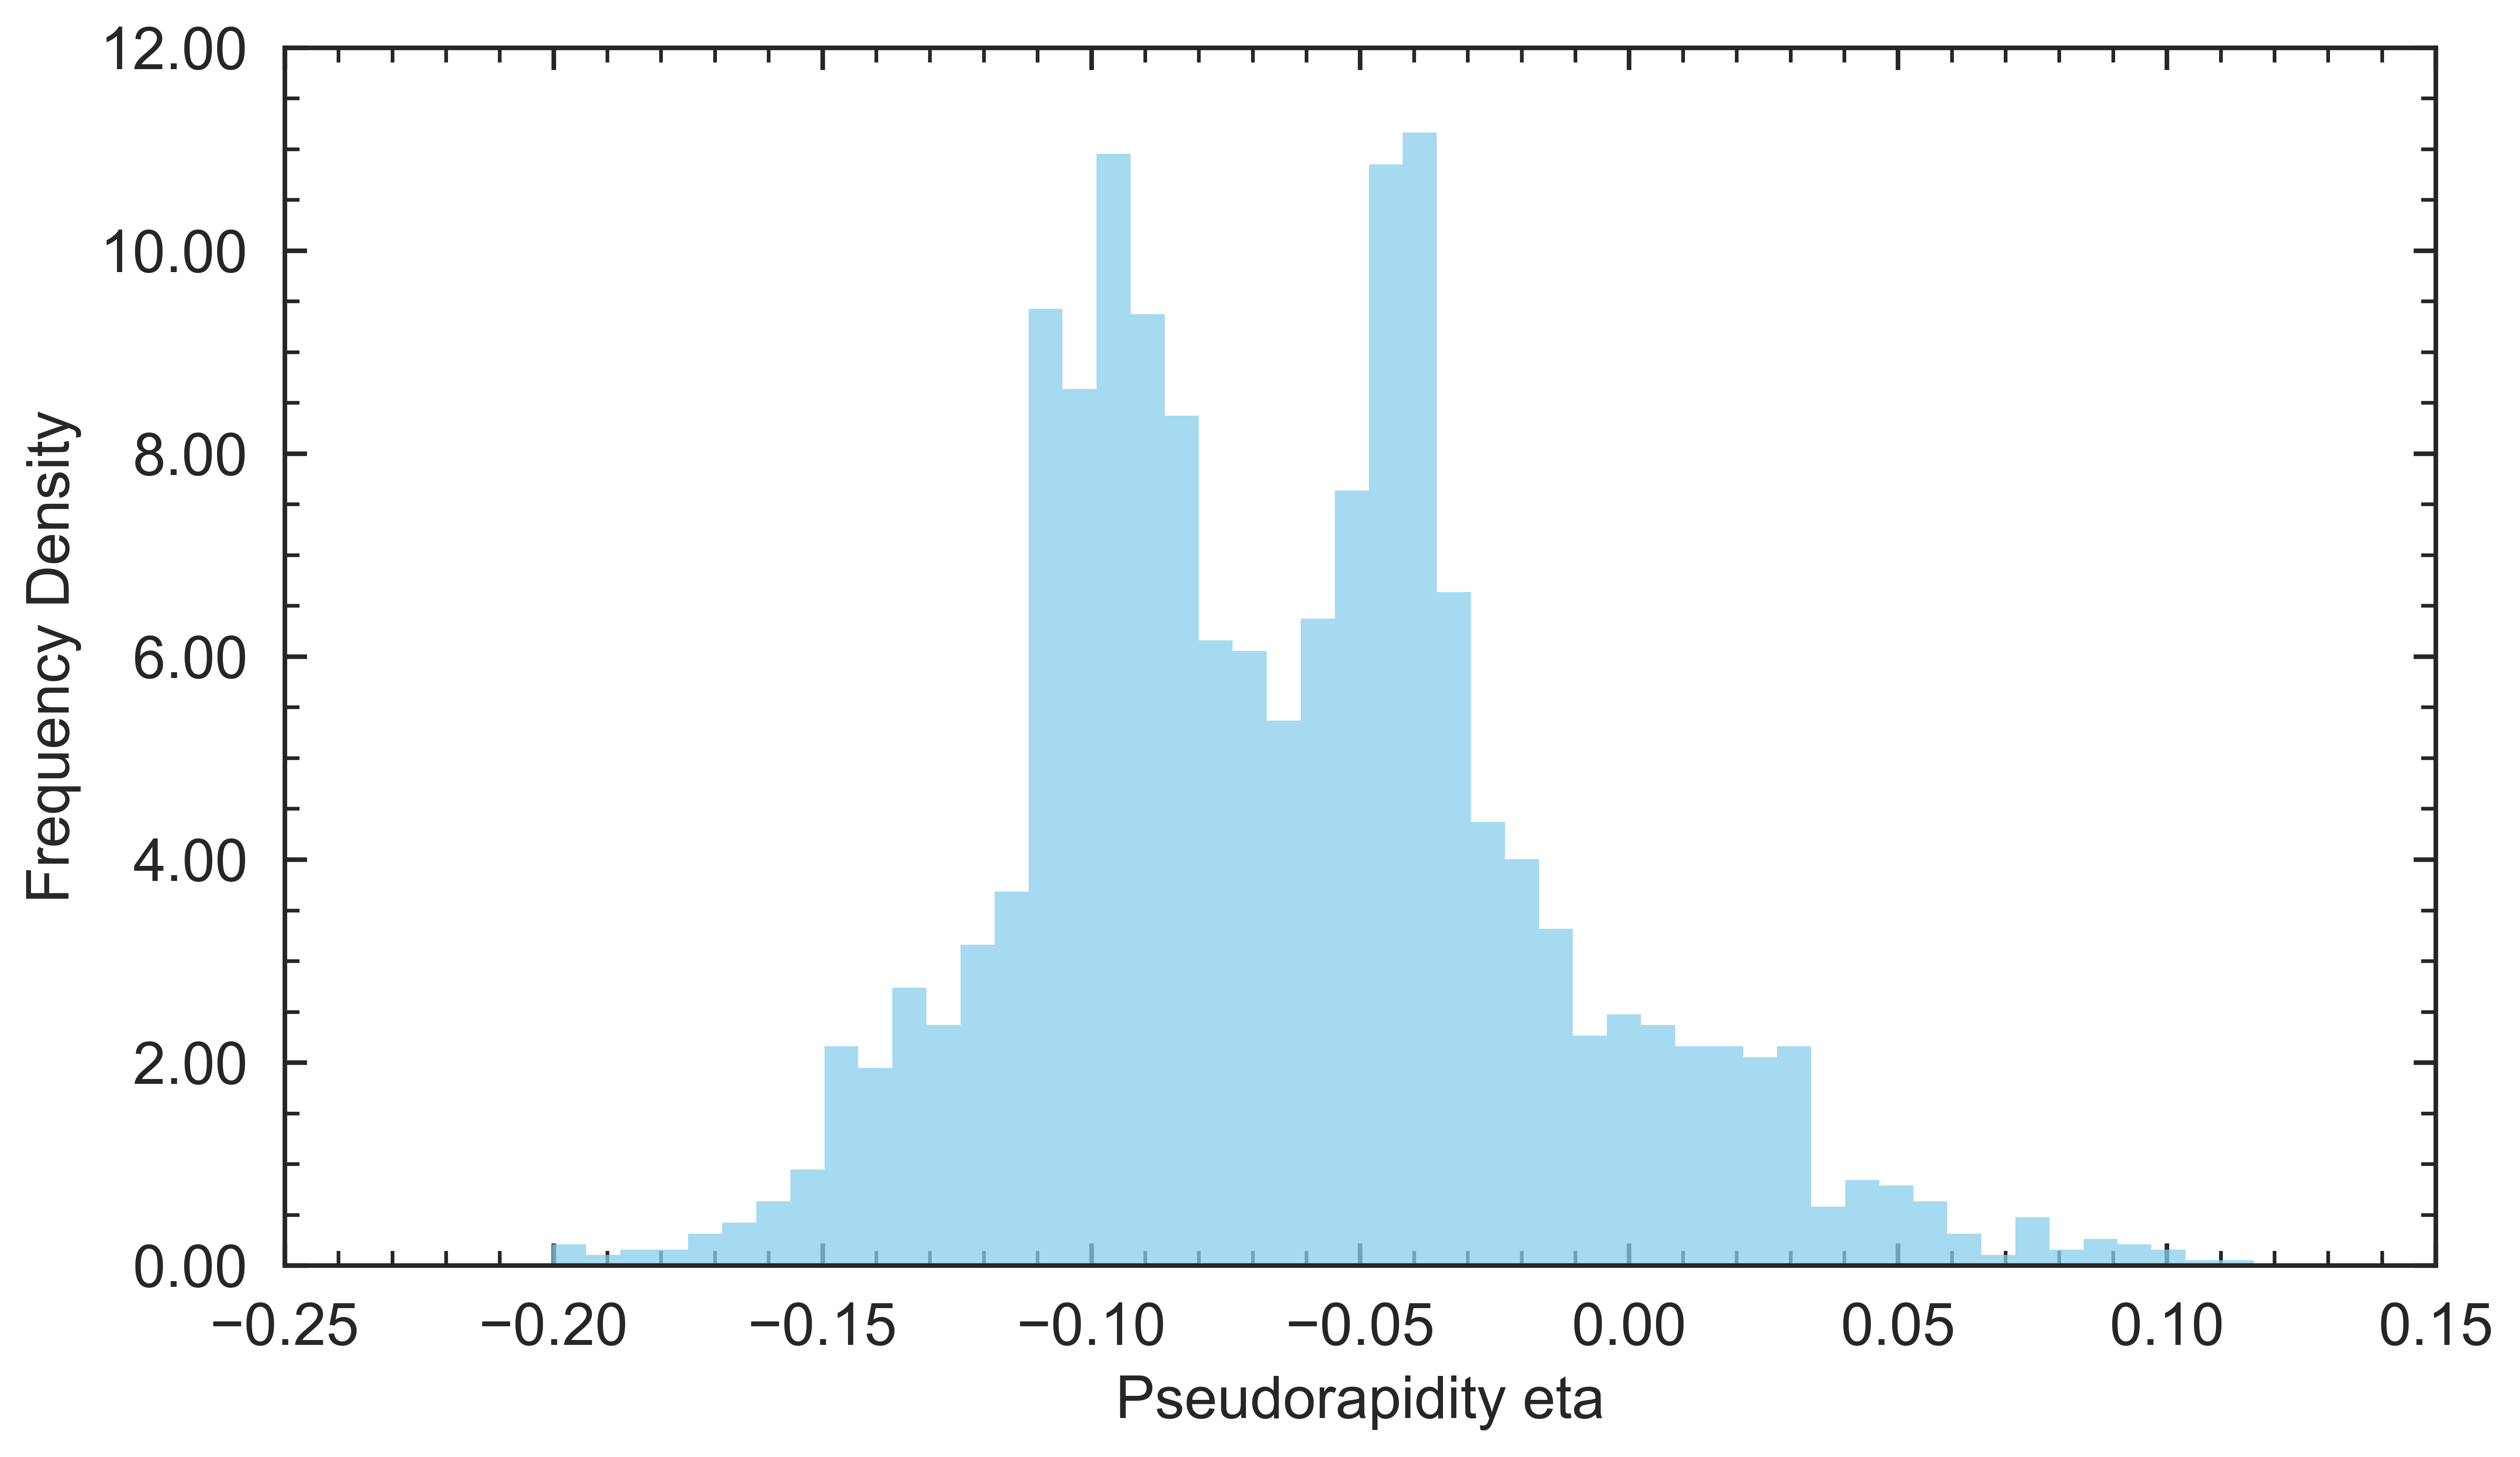

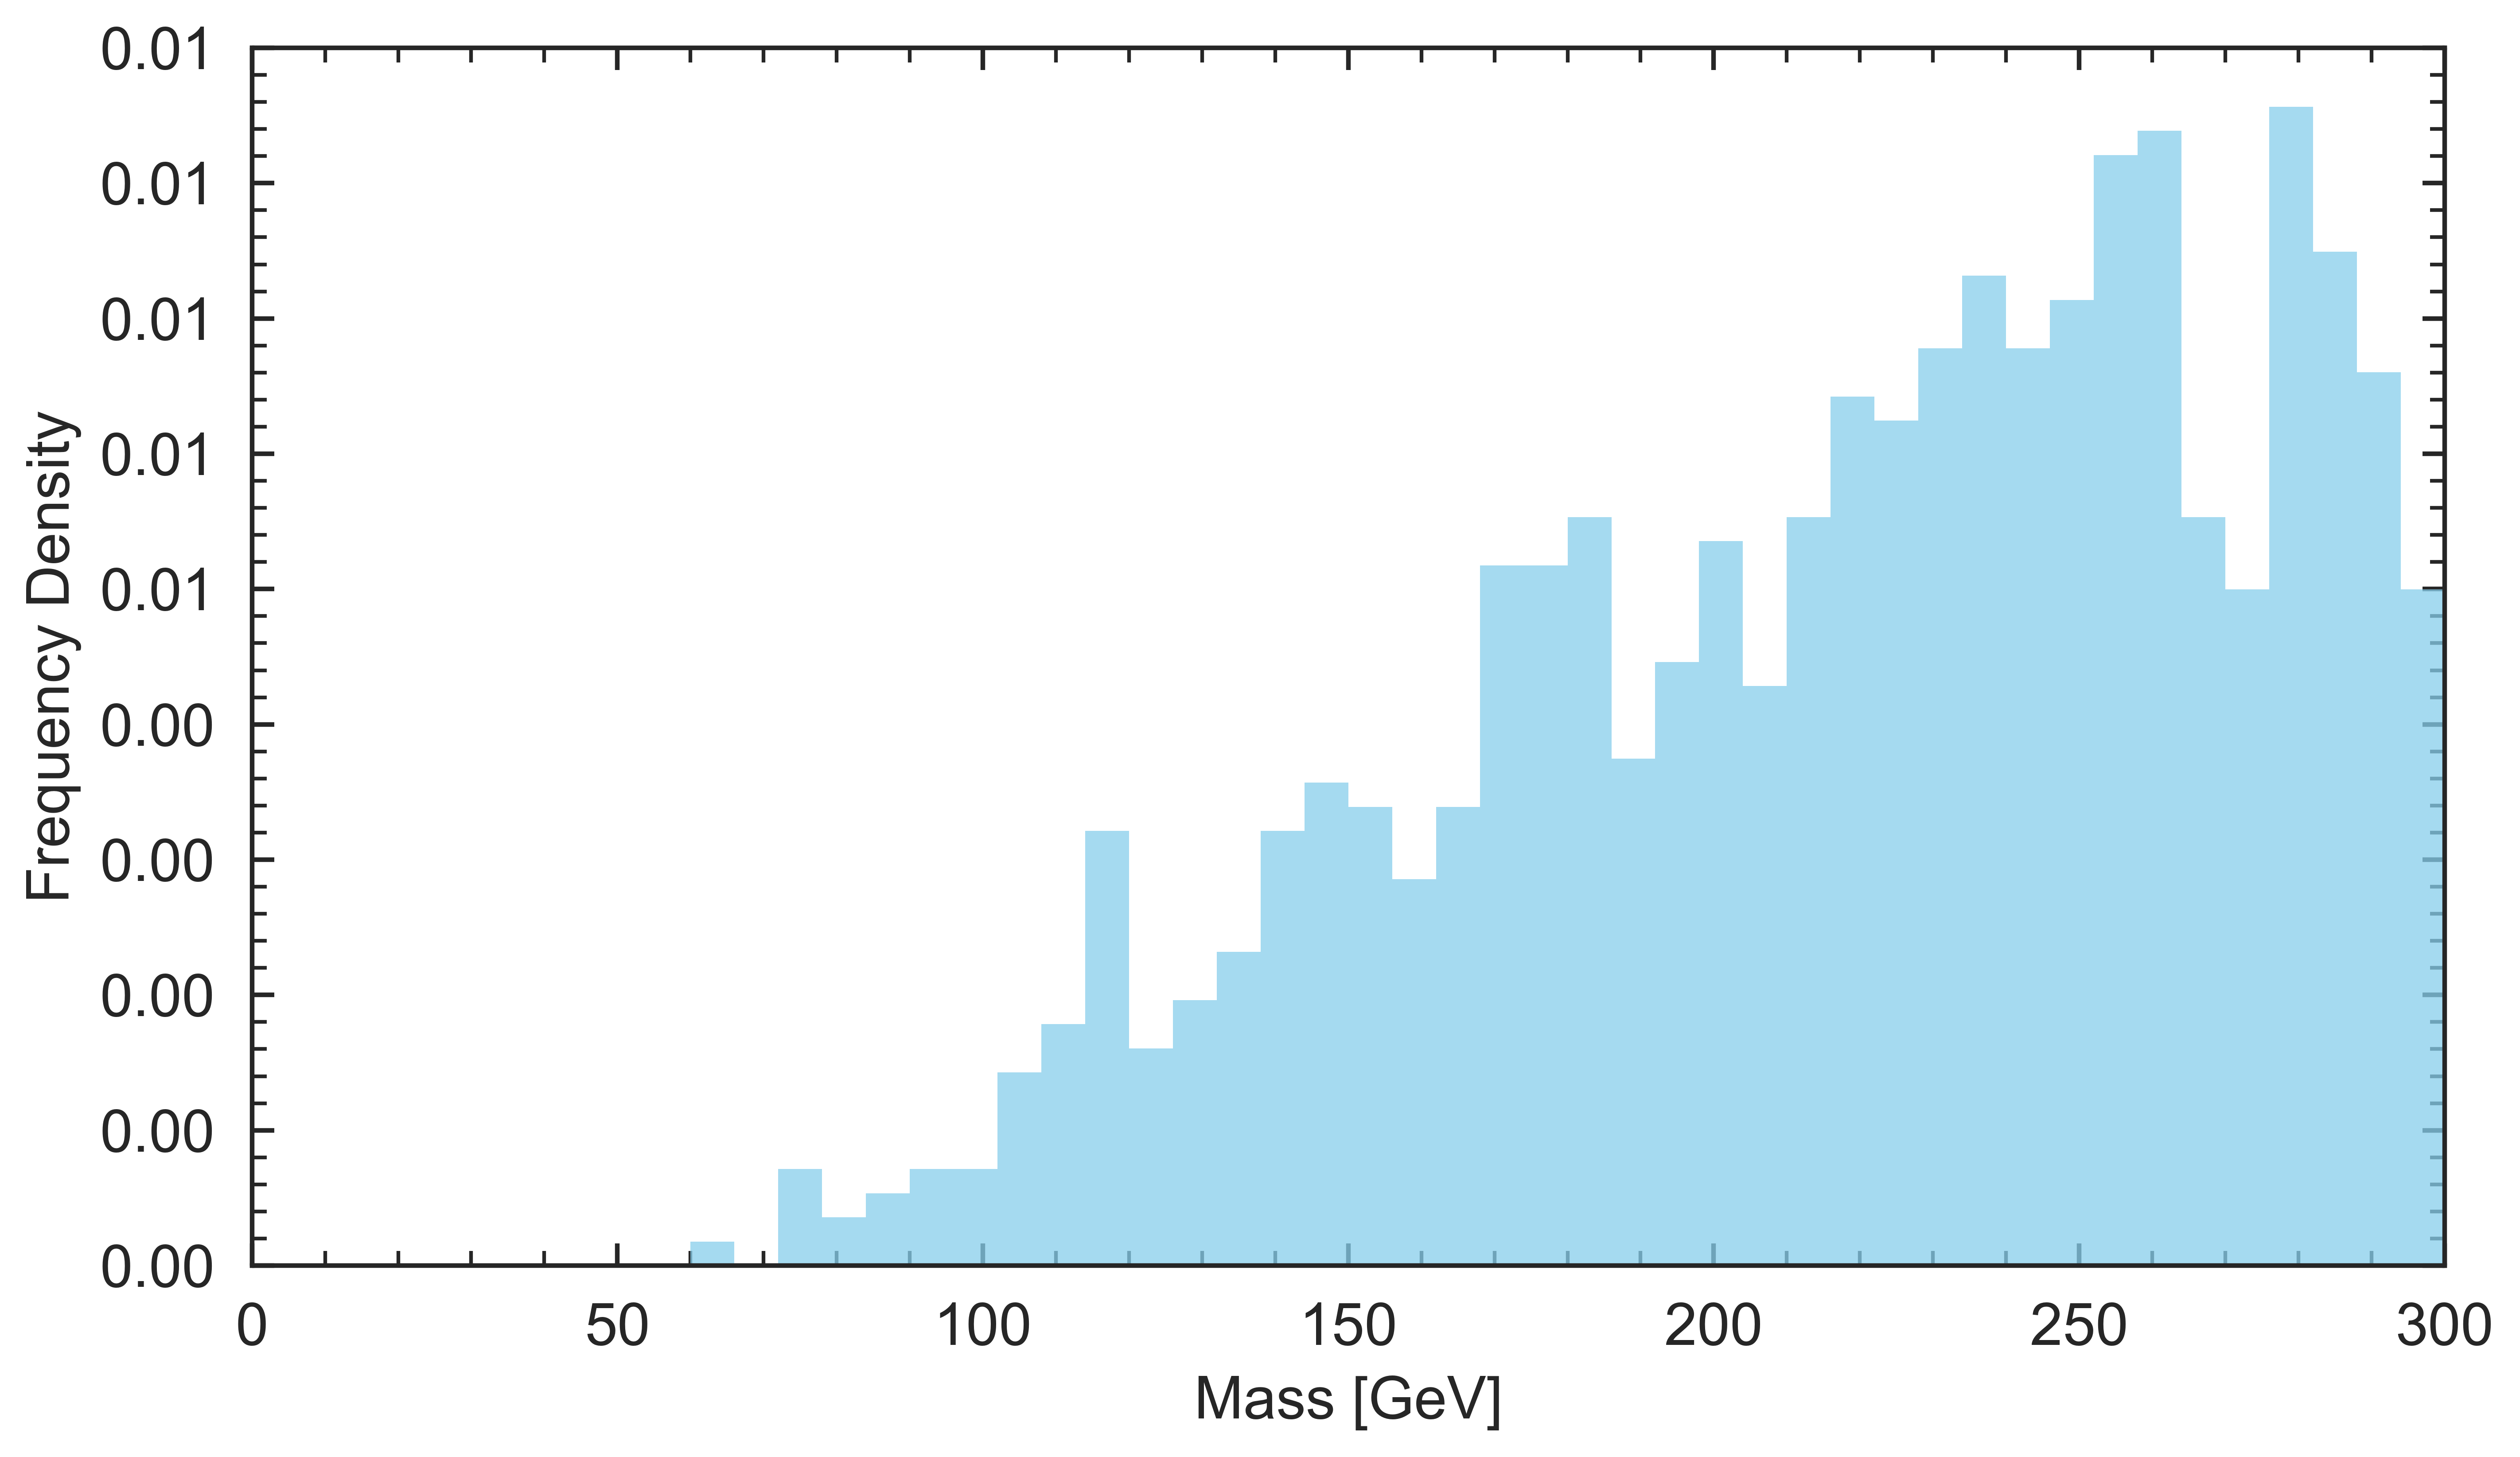

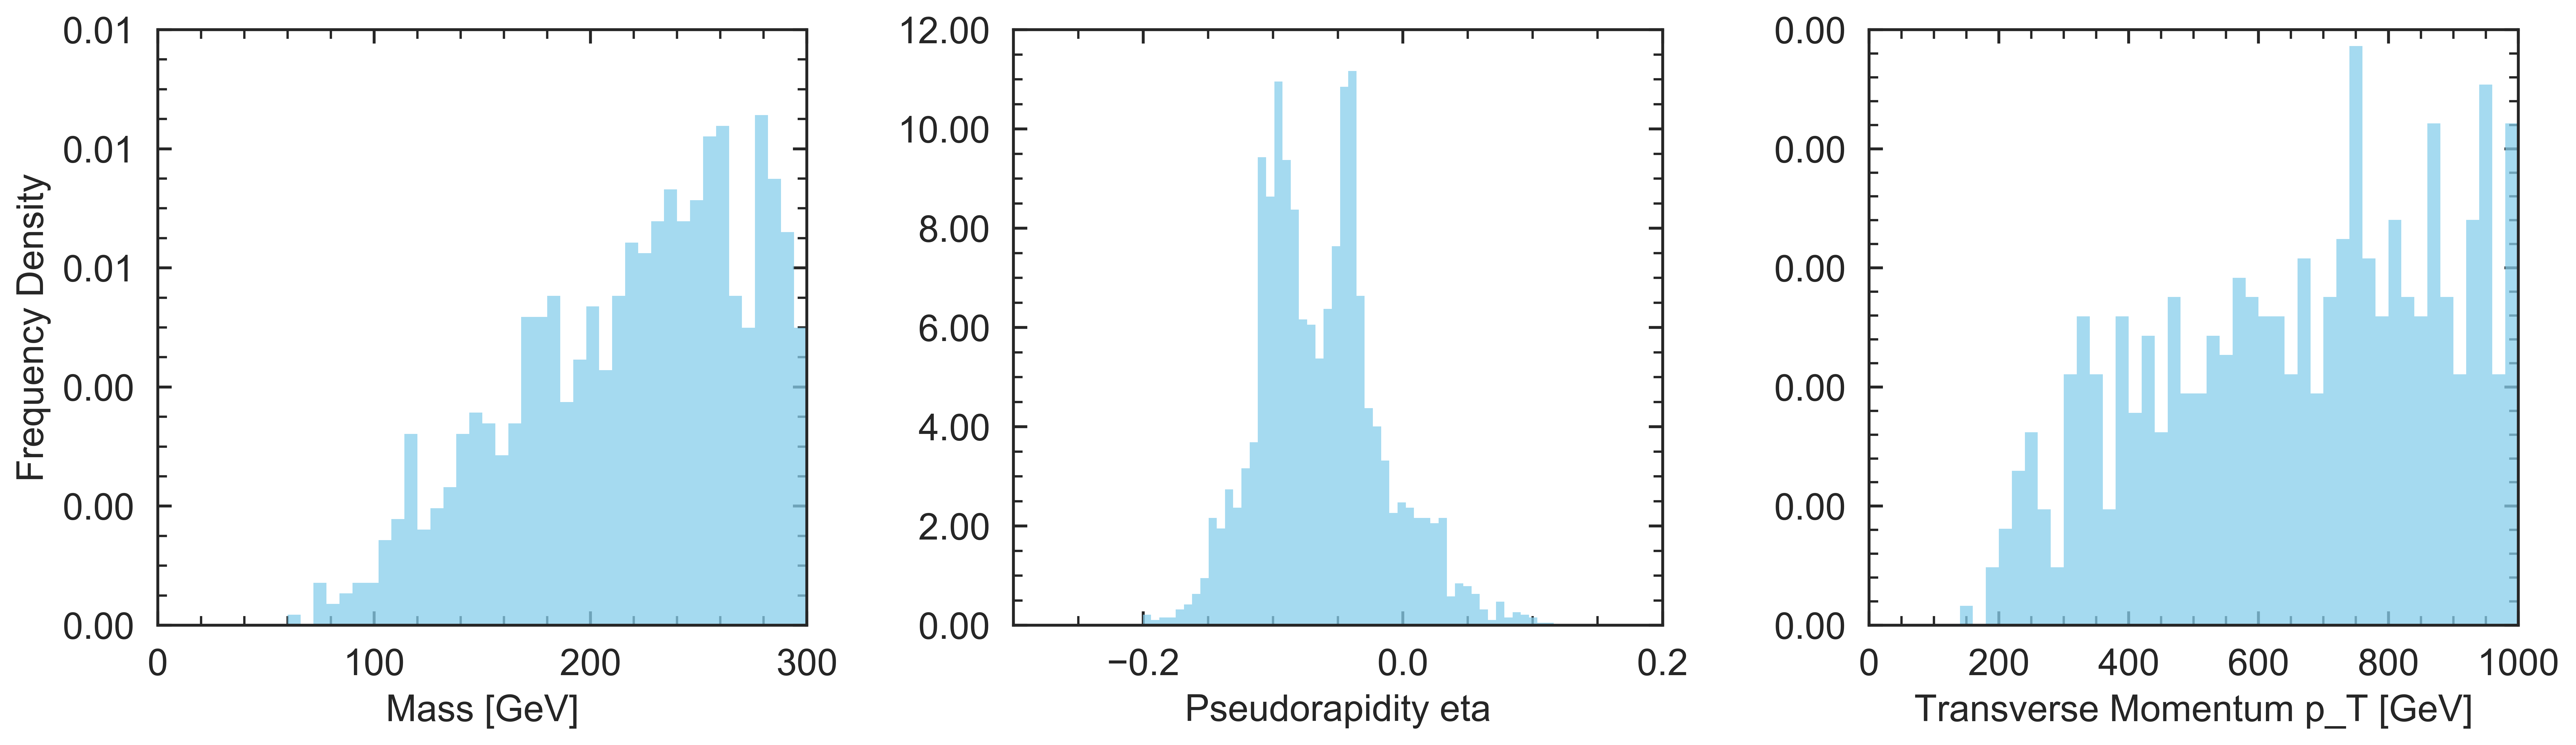

In [15]:
# Data post-processing
mu = 200
output_path = f"{CWD}/data/3-grid"
output_filename = f"noisy_mu{mu}_event_level_from_grid{bins}.csv"
output_filepath = f"{output_path}/{output_filename}"
histogram_path = f"{output_path}/grid{bins}_hist"
mpl.rcParams.update(MPL_GLOBAL_PARAMS)
if not(os.path.exists(output_path)):
    os.mkdir(output_path)
if not(os.path.exists(histogram_path)):
    os.mkdir(histogram_path)
    
# generator = NoisyGenerator(tt, pile_up, mu=mu)
combined = []
def grid_to_ene_deta_dphi(grid, N=BMAP_SQUARE_SIDE_LENGTH):
    enes = np.zeros(N*N)
    detas = np.zeros(N*N)
    dphis = np.zeros(N*N)
    # xbin and ybin may be wrong way around
    for xbin in range(N):
        for ybin in range(N):
            idx = xbin*N + ybin
            deta = 2*xbin/N - 1
            dphi = 2*ybin/N - 1
            enes[idx] = grid[ybin, xbin]
            detas[idx] = deta
            dphis[idx] = dphi
    return enes, detas, dphis
def tensor_to_data(tensor_images):
    tensor_images_cpu = tensor_images.detach().cpu().numpy()
    tensor_saves = tensor_images[:48]
    save_image(tensor_saves, f"{histogram_path}/saved_denoised_grids2.png")
    for idx,grid in enumerate(tensor_images_cpu):
        # Each grid is 1 x bins x bins
        hxW = grid[0] # Selects bins x bins
        enes, detas, dphis = grid_to_ene_deta_dphi(hxW, N=bins)
        pxs, pys, pzs = deta_dphi_to_momenta(enes, detas, dphis)
        event_quantities = particle_momenta_to_event_level(enes, pxs, pys, pzs)
        event_mass, event_px, event_py, event_pz, event_eta, event_phi, event_pT = event_quantities

        event_level = np.array([
            idx,
            event_px,
            event_py,
            event_pz,
            event_eta,
            event_phi,
            event_mass,
            event_pT,
        ])

        combined.append(np.copy(event_level))
    all_data = np.vstack(combined)

    # Final check before saving
    if np.any(np.isnan(all_data)):
        print("\nWarning: NaN values in final data:")
        print(f"Total NaN count: {np.sum(np.isnan(all_data))}")
        print("NaN locations (row, column):")
        nan_rows, nan_cols = np.where(np.isnan(all_data))
        column_names = ['event_id', 'px', 'py', 'pz', 'eta', 'phi', 'mass', 'p_T']
        for row, col in zip(nan_rows, nan_cols):
            print(f"Row {row}, Column {column_names[col]}")
    

    np.savetxt(
            output_filepath,
            all_data,
            delimiter=",",
            header="event_id,px,py,pz,eta,phi,mass,p_T",
            comments="",
            fmt="%i,%10.10f,%10.10f,%10.10f,%10.10f,%10.10f,%10.10f,%10.10f"
        )
    
    # Here mu is the initial mu we set simulations to start from
    plot_1d_histograms(mu, event_stats_path=output_filepath, output_path=f"{output_path}/grid{bins}_hist")

    # Tensors are current;y in BxCxHxW tensor
    # Want to ex
# for idx, _ in enumerate(generator):
#     grid = generator.get_grid()
    
    
# rescaled = sampled_images * NG_jet.max_energy
# tensor_to_data(rescaled)
# np.savetxt(f"tensor_data_denoised.txt", rescaled_np,delimiter=",")

tensor_to_data(rescaled)

In [14]:
# class PileupDiffusion(GaussianDiffusion):
#     def __init__(
#         self,
#         model,
#         *,
#         image_size,
#         timesteps = 1000,
#         sampling_timesteps = None,
#         objective = 'pred_v',
#         beta_schedule = 'sigmoid',
#         schedule_fn_kwargs = dict(),
#         ddim_sampling_eta = 0.,
#         auto_normalize = True,
#         offset_noise_strength = 0.,  # https://www.crosslabs.org/blog/diffusion-with-offset-noise
#         min_snr_loss_weight = False, # https://arxiv.org/abs/2303.09556
#         min_snr_gamma = 5,
#         immiscible = False
#     ):
#         super().__init__()